ECEN Project 1 by Group 6 Extra credit: Multi-modal Zero-shot
Classification

Team members: Hareen Sai Vattikuti, Jessica Rumsey, Muzi Zhou,
Prajnadipta Kundu, Shuvam Chowdhury

Dataset: FashionMNIST ( https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html#torchvision.datasets.FashionMNIST )

References: [1] G. Eason, B. Noble, and I. N. Sneddon, “On certain integrals of Lipschitz-Hankel type involving products of Bessel functions,” Phil. Trans. Roy. Soc. London, vol. A247, pp. 529–551, April 1955. (references) [2] J. Clerk Maxwell, A Treatise on Electricity and Magnetism, 3rd ed., vol. 2. Oxford: Clarendon, 1892, pp.68–73. [3] I. S. Jacobs and C. P. Bean, “Fine particles, thin films and exchange anisotropy,” in Magnetism, vol. III, G. T. Rado and H. Suhl, Eds. New York: Academic, 1963, pp. 271–350. [4] K. Elissa, “Title of paper if known,” unpublished. [5] R. Nicole, “Title of paper with only first word capitalized,” J. Name Stand. Abbrev., in press. [6] Y. Yorozu, M. Hirano, K. Oka, and Y. Tagawa, “Electron spectroscopy studies on magneto-optical media and plastic substrate interface,” IEEE Transl. J. Magn. Japan, vol. 2, pp. 740–741, August 1987 [Digests 9th Annual Conf. Magnetics Japan, p. 301, 1982]. [7] M. Young, The Technical Writer’s Handbook. Mill Valley, CA: University Science, 1989. [8] K. Eves and J. Valasek, “Adaptive control for singularly perturbed systems examples,” Code Ocean, Aug. 2023. [Online]. Available: https://codeocean.com/capsule/4989235/tree [9] ChatGPT

In [3]:
pip install transformers torchvision torch

Note: you may need to restart the kernel to use updated packages.


In [4]:
# Import necessary libraries
import torch
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

100%|██████████████████████████████████████| 26.4M/26.4M [00:02<00:00, 9.43MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|███████████████████████████████████████| 29.5k/29.5k [00:00<00:00, 232kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████████████████████████████████| 4.42M/4.42M [00:01<00:00, 3.37MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 4.34MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Image min: 0.0, max: 1.0
Model: openai/clip-vit-base-patch32, Accuracy: 0.6236
Model: openai/clip-vit-base-patch16, Accuracy: 0.6803
Model: openai/clip-vit-large-patch14, Accuracy: 0.6413

Summary of CLIP Model Variant Performance:
openai/clip-vit-base-patch32: 0.6236
openai/clip-vit-base-patch16: 0.6803
openai/clip-vit-large-patch14: 0.6413

Best Model: openai/clip-vit-base-patch16, Accuracy: 0.6803

Evaluation Metrics for Best Model:
Accuracy: 0.6803
Precision: 0.7008
Recall: 0.6803
F1-score: 0.6705


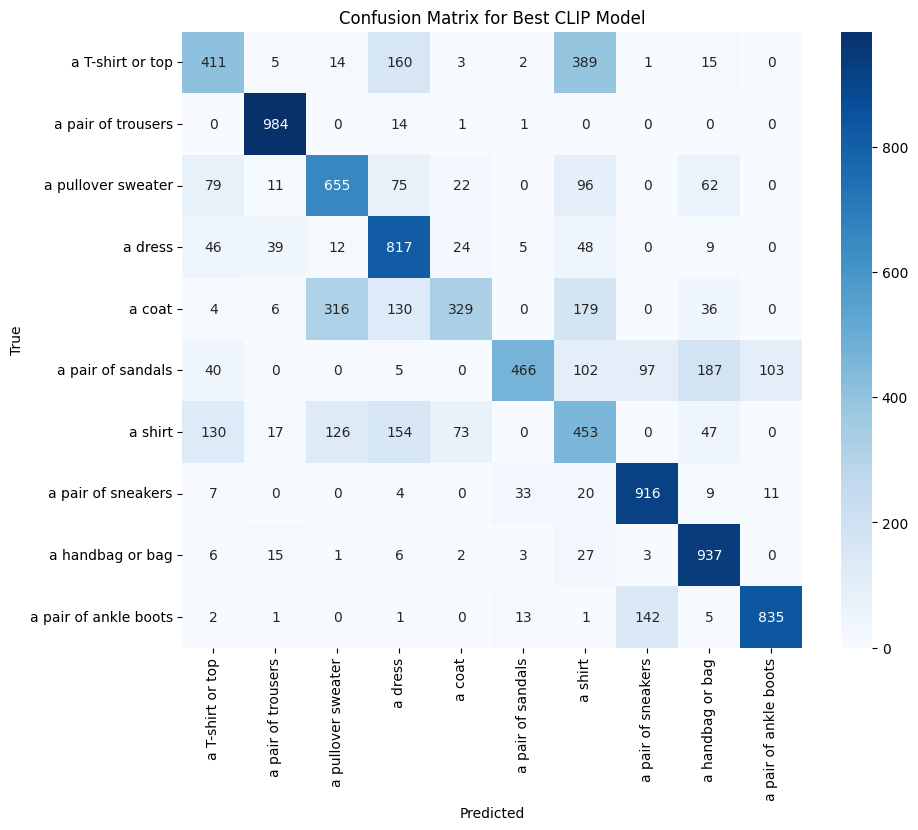

In [5]:
# Define preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match CLIP's input size
    transforms.Grayscale(3),       # Convert grayscale to 3-channel
    transforms.ToTensor(),         # Convert to PyTorch tensor
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))  # Scale to [0, 1]
])


# Load FashionMNIST dataset with the transformation
test_dataset = FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verify pixel range of images
images, labels = next(iter(test_loader))
print(f"Image min: {images.min().item()}, max: {images.max().item()}")  # Should be [0, 1]


# Optimized FashionMNIST class labels
class_labels = [
    "a T-shirt or top",
    "a pair of trousers",
    "a pullover sweater",
    "a dress",
    "a coat",
    "a pair of sandals",
    "a shirt",
    "a pair of sneakers",
    "a handbag or bag",
    "a pair of ankle boots"
]



# Function to evaluate a CLIP model variant
def evaluate_clip_variant(model_name):
    # Load the CLIP model and processor
    model = CLIPModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")
    processor = CLIPProcessor.from_pretrained(model_name)

    y_pred, y_true = [], []

    # Disable gradient computation for inference
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to("cuda" if torch.cuda.is_available() else "cpu")

            # Prepare inputs for the CLIP processor
            inputs = processor(
                text=class_labels,
                images=images,
                return_tensors="pt",
                padding=True,
                do_rescale=False  # Avoid redundant rescaling
            )
            inputs = {key: value.to("cuda" if torch.cuda.is_available() else "cpu") for key, value in inputs.items()}

            # Perform inference
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1)  # Convert logits to probabilities

            # Get predictions
            predictions = torch.argmax(probs, dim=1).cpu().tolist()
            y_pred.extend(predictions)
            y_true.extend(targets.tolist())

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Model: {model_name}, Accuracy: {accuracy:.4f}")
    return accuracy



# List of CLIP variants to evaluate
clip_variants = [
    "openai/clip-vit-base-patch32",
    "openai/clip-vit-base-patch16",
    "openai/clip-vit-large-patch14",
]

# Evaluate all variants
results = {}
for variant in clip_variants:
    results[variant] = evaluate_clip_variant(variant)

# Print summary of results
print("\nSummary of CLIP Model Variant Performance:")
for variant, accuracy in results.items():
    print(f"{variant}: {accuracy:.4f}")

# Plot confusion matrix for the best model
best_model = max(results, key=results.get)
print(f"\nBest Model: {best_model}, Accuracy: {results[best_model]:.4f}")

# Reload best model and calculate detailed metrics
model = CLIPModel.from_pretrained(best_model).to("cuda" if torch.cuda.is_available() else "cpu")
processor = CLIPProcessor.from_pretrained(best_model)

y_pred, y_true = [], []

with torch.no_grad():
    for images, targets in test_loader:
        images = images.to("cuda" if torch.cuda.is_available() else "cpu")
        inputs = processor(
            text=class_labels,
            images=images,
            return_tensors="pt",
            padding=True,
            do_rescale=False
        )
        inputs = {key: value.to("cuda" if torch.cuda.is_available() else "cpu") for key, value in inputs.items()}

        outputs = model(**inputs)
        logits_per_image = outputs.logits_per_image
        probs = logits_per_image.softmax(dim=1)

        predictions = torch.argmax(probs, dim=1).cpu().tolist()
        y_pred.extend(predictions)
        y_true.extend(targets.tolist())

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="macro")
recall = recall_score(y_true, y_pred, average="macro")
f1 = f1_score(y_true, y_pred, average="macro")

print("\nEvaluation Metrics for Best Model:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_labels))))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Best CLIP Model")
plt.show()

Image min: 0.0, max: 1.0

Accuracy for Each Prompt:
Prompt: 'a photo of a {}', Accuracy: 0.6225
Prompt: 'a centered photo of a {}', Accuracy: 0.6535
Prompt: 'a grayscale photo of a {}', Accuracy: 0.6658
Prompt: 'a centered image of a {}', Accuracy: 0.7115
Prompt: 'this is a photo of a {}', Accuracy: 0.6438

Best Prompt: 'a centered image of a {}' with Accuracy: 0.7115

Evaluation Metrics for Best Prompt:
Accuracy: 0.7115
Precision: 0.7125
Recall: 0.7115
F1-score: 0.7048


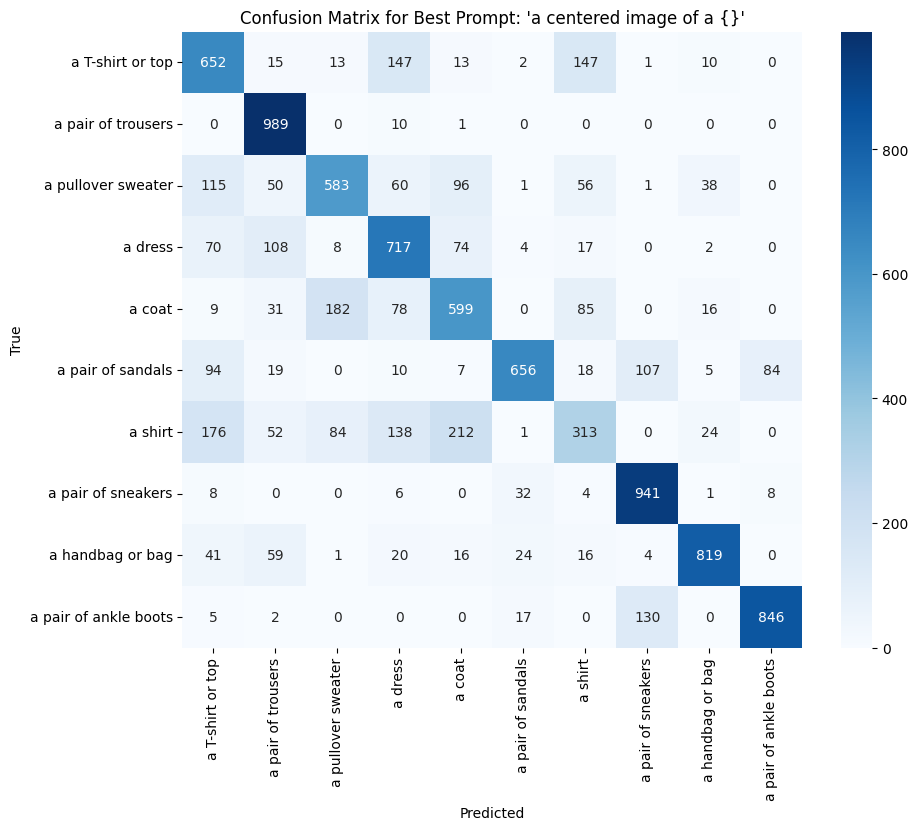

In [6]:
# Define preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match CLIP's input size
    transforms.Grayscale(3),       # Convert grayscale to 3-channel
    transforms.ToTensor(),         # Convert to PyTorch tensor
    transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))  # Scale to [0, 1]
])

# Load FashionMNIST dataset with the transformation
test_dataset = FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Verify pixel range of images
images, labels = next(iter(test_loader))
print(f"Image min: {images.min().item()}, max: {images.max().item()}")  # Should be [0, 1]

# Optimized FashionMNIST class labels
class_labels = [
    "a T-shirt or top",
    "a pair of trousers",
    "a pullover sweater",
    "a dress",
    "a coat",
    "a pair of sandals",
    "a shirt",
    "a pair of sneakers",
    "a handbag or bag",
    "a pair of ankle boots"
]

# Define templates for prompts
templates = [
    "a photo of a {}",
    "a centered photo of a {}",
    "a grayscale photo of a {}",
    "a centered image of a {}",
    "this is a photo of a {}"
]

# Load the CLIP model and processor
model_name = "openai/clip-vit-base-patch16"
model = CLIPModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")
processor = CLIPProcessor.from_pretrained(model_name)

# Evaluate the model with accuracy for each prompt
prompt_accuracies = {}
metrics_for_best_prompt = {}

with torch.no_grad():
    for template in templates:
        # Generate specific prompts for each class using the current template
        current_prompts = [template.format(label) for label in class_labels]

        y_pred, y_true = [], []

        for images, targets in test_loader:
            images = images.to("cuda" if torch.cuda.is_available() else "cpu")

            # Prepare inputs for the CLIP processor
            inputs = processor(
                text=current_prompts,
                images=images,
                return_tensors="pt",
                padding=True,
                do_rescale=False  # Avoid redundant rescaling
            )
            inputs = {key: value.to("cuda" if torch.cuda.is_available() else "cpu") for key, value in inputs.items()}

            # Perform inference
            outputs = model(**inputs)
            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1)  # Convert logits to probabilities

            # Get predictions
            predictions = torch.argmax(probs, dim=1).cpu().tolist()
            y_pred.extend(predictions)
            y_true.extend(targets.tolist())

        # Calculate accuracy for the current prompt
        accuracy = accuracy_score(y_true, y_pred)
        prompt_accuracies[template] = accuracy

        # If this is the best-performing prompt so far, calculate evaluation metrics
        if accuracy == max(prompt_accuracies.values()):
            precision = precision_score(y_true, y_pred, average="macro")
            recall = recall_score(y_true, y_pred, average="macro")
            f1 = f1_score(y_true, y_pred, average="macro")
            cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_labels))))
            metrics_for_best_prompt = {
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1-score": f1,
                "Confusion Matrix": cm
            }

# Print accuracy for each prompt
print("\nAccuracy for Each Prompt:")
for template, accuracy in prompt_accuracies.items():
    print(f"Prompt: '{template}', Accuracy: {accuracy:.4f}")

# Identify the best-performing prompt
best_prompt = max(prompt_accuracies, key=prompt_accuracies.get)
print(f"\nBest Prompt: '{best_prompt}' with Accuracy: {metrics_for_best_prompt['Accuracy']:.4f}")

# Print evaluation metrics for the best prompt
print("\nEvaluation Metrics for Best Prompt:")
print(f"Accuracy: {metrics_for_best_prompt['Accuracy']:.4f}")
print(f"Precision: {metrics_for_best_prompt['Precision']:.4f}")
print(f"Recall: {metrics_for_best_prompt['Recall']:.4f}")
print(f"F1-score: {metrics_for_best_prompt['F1-score']:.4f}")

# Plot confusion matrix for the best prompt
plt.figure(figsize=(10, 8))
sns.heatmap(
    metrics_for_best_prompt["Confusion Matrix"],
    annot=True, fmt="d", cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Confusion Matrix for Best Prompt: '{best_prompt}'")
plt.show()